# EUROSAT Cnn optimization


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# GPU Config
import tensorflow as tf

# Check available GPUs
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    print("No GPU devices found. Ensure your system recognizes the GPU.")
else:
    try:
        # Limit TensorFlow to use only the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print(f"Configured TensorFlow to use GPU: {gpus[0].name}")

        # Enable dynamic memory growth on the GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Memory growth enabled for the first GPU.")

        # Optional: Display additional GPU configuration details
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Physical GPUs: {len(gpus)}, Logical GPUs: {len(logical_gpus)}")

    except RuntimeError as e:
        print(f"RuntimeError during GPU setup: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Further GPU diagnostics
print("TensorFlow version:", tf.__version__)
print("CUDA device detected:", tf.test.is_built_with_cuda())
print("GPU availability:", tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))


2024-11-11 14:30:55.270247: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-11 14:30:55.363002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 14:30:55.400342: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 14:30:55.412735: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 14:30:55.482994: I tensorflow/core/platform/cpu_feature_guar

Configured TensorFlow to use GPU: /physical_device:GPU:0
Memory growth enabled for the first GPU.
Physical GPUs: 1, Logical GPUs: 1
TensorFlow version: 2.17.0
CUDA device detected: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU availability: True


I0000 00:00:1731346256.963601    5071 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731346257.028771    5071 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731346257.028920    5071 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731346257.030502    5071 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Download the data

In [4]:
import os

# Set your condition
download_condition = False  # Replace this with your actual condition

if download_condition:
    # Check if the 'data' directory exists, if not create it
    if not os.path.exists('./data'):
        os.makedirs('./data')

    # Download the file and unzip it
    !wget https://madm.dfki.de/files/sentinel/EuroSAT.zip -P /tmp/ --no-check-certificate
    !unzip -qq /tmp/EuroSAT.zip -d ./data/

else:
    print("Download condition not met. Skipping download.")


Download condition not met. Skipping download.


In [5]:
from eurosat_model import count_images_in_subdirectories
# Define the parent directory and subdirectories
parent_directory = './data/2750/'  # Change this to your directory path
subdirectories = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 
                  'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 
                  'River', 'SeaLake']

# Count the total number of images
total_images = count_images_in_subdirectories(parent_directory, subdirectories)
print(f"Total number of images across all subdirectories: {total_images}")


Number of images in 'AnnualCrop': 3000
Number of images in 'Forest': 3000
Number of images in 'HerbaceousVegetation': 3000
Number of images in 'Highway': 2500
Number of images in 'Industrial': 2500
Number of images in 'Pasture': 2000
Number of images in 'PermanentCrop': 2500
Number of images in 'Residential': 3000
Number of images in 'River': 2500
Number of images in 'SeaLake': 3000
Total number of images across all subdirectories: 27000


# Load the data for exploration

In [6]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set the path to the EuroSAT dataset directory after unzipping
data_dir = './data/2750/'

# Define image size
img_size = (64, 64)  # EuroSAT images are 64x64

# Initialize empty lists for images and labels
images = []
labels = []
class_names = []

# Loop through each class directory and load images
for i, class_name in enumerate(sorted(os.listdir(data_dir))):
    class_path = os.path.join(data_dir, class_name)
    
    # Check if it's a directory
    if os.path.isdir(class_path):
        class_names.append(class_name)
        
        # Loop through all image files in the class directory
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            
            # Open and preprocess image
            img = Image.open(img_path).convert('RGB')
            img = img.resize(img_size)  # Resize image
            img = np.array(img) / 255.0  # Normalize pixel values
            
            # Append image and corresponding label
            images.append(img)
            labels.append(i)  # Label is the index of the class

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

print(f"Loaded {len(X_train)} training images and {len(X_val)} validation images.")
print(f"Class Names: {class_names}")

Loaded 21600 training images and 5400 validation images.
Class Names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [7]:
y_train[0] #label

0

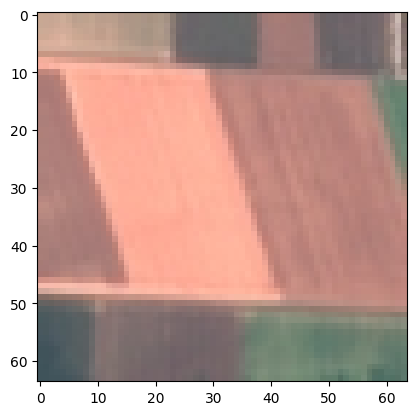

In [8]:
plt.imshow(X_train[0]); #image

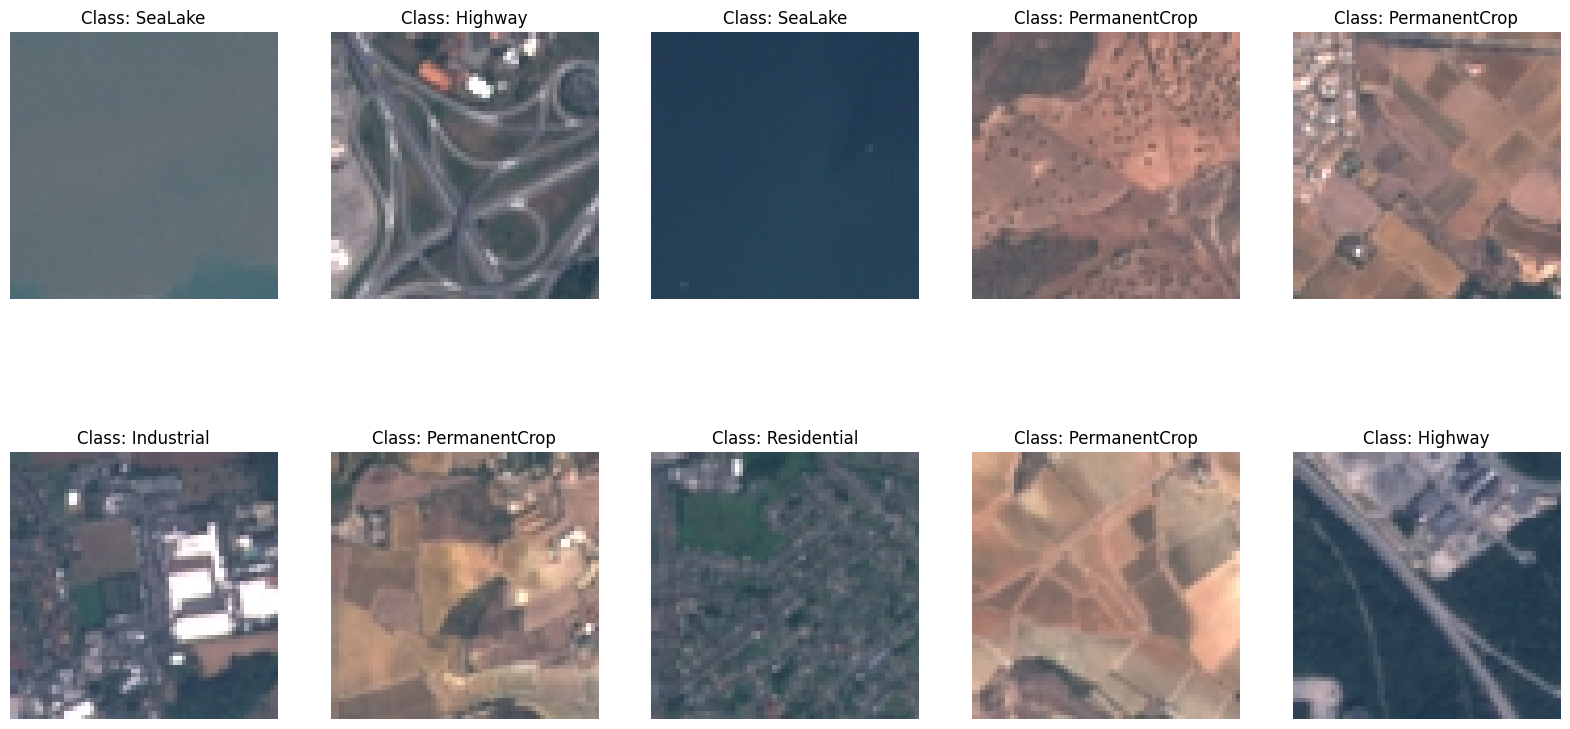

In [9]:
from eurosat_model import plot_images

# Plot a few images from the training dataset
plot_images(X_train, y_train, class_names, num_images=10)

# 1. Build a simple Cnn

In [10]:
# Import necessary functions from the eurosat_model script
from eurosat_model import (
    create_data_generators, 
    build_cnn_model,
    build_cnn_model_with_regularization, 
    train_model, 
    plot_training_history
    )

In [11]:
# Input shape and number of classes for EuroSAT
input_shape = (64, 64, 3)
num_classes = 10  # classes in EuroSAT

# Build and summarize the CNN model
model_A = build_cnn_model(input_shape, num_classes)
model_A.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,458,186 (9.38 MB)

 Trainable params: 2,458,186 (9.38 MB)

 Non-trainable params: 0 (0.00 B)

# 2. Data Augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to the EuroSAT dataset directory after unzipping
data_dir = './data/2750/'

# Define image size and batch size for preprocessing
img_size = (64, 64)  # EuroSAT images are 64x64
batch_size = 32

# Create an image data generator with data augmentation (not rescaling!)
datagen_aug = ImageDataGenerator(
    rotation_range=40,        # Rotate the image up to 40 degrees
    width_shift_range=0.2,    # Shift the image horizontally by 20% of the width
    height_shift_range=0.2,   # Shift the image vertically by 20% of the height
    shear_range=0.2,          # Apply shear transformations
    zoom_range=0.2,           # Zoom in/out by 20%
    horizontal_flip=True,     # Flip images horizontally
    fill_mode='nearest',      # Fill pixels after transformation
    validation_split=0.2      # Reserve 20% of the data for validation
)

# Load the training set
train_generator_aug = datagen_aug.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use subset='training' to load the training set
)

# Load the validation set
val_generator = datagen_aug.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use subset='validation' to load the validation set
)

# Get the class names (directories inside the EuroSAT dataset folder)
class_names = list(train_generator_aug.class_indices.keys())
print("Class Names:", class_names)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
Class Names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [13]:
from eurosat_model import visualize_augmented_images

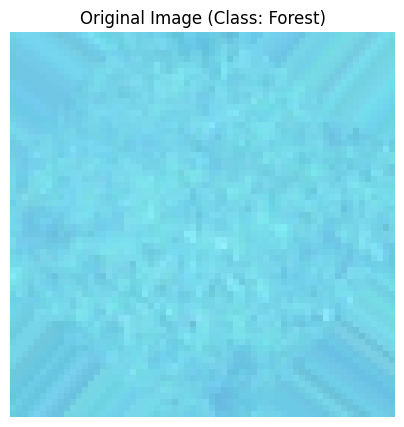

Image 1 pixel range: min=31.025754928588867, max=77.0067138671875


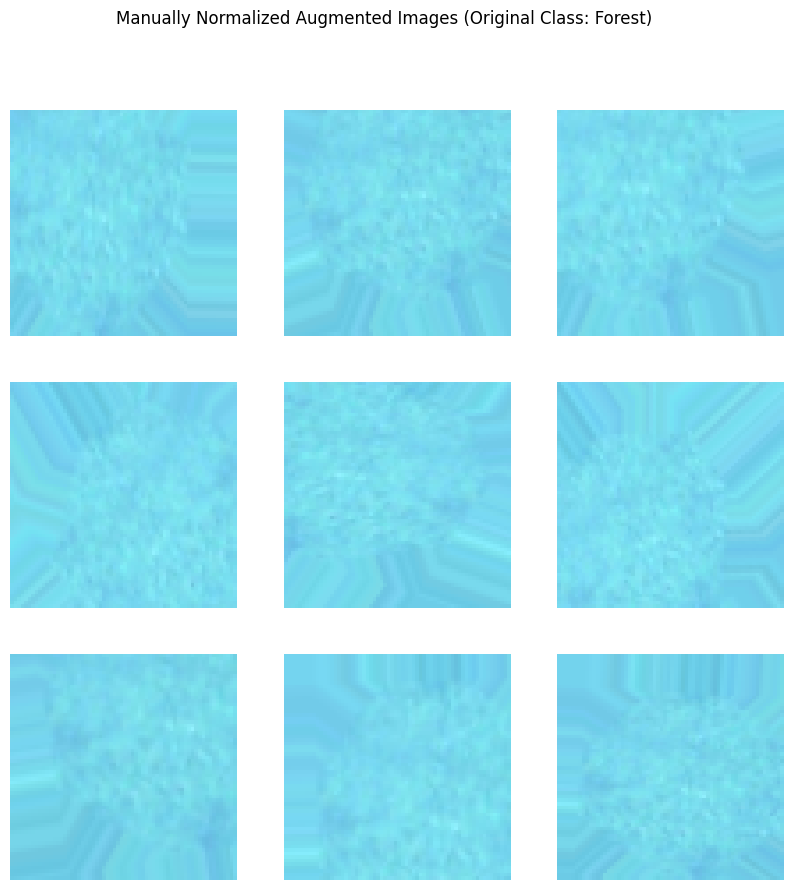

In [14]:
# Extract one batch of images and labels for visualization
X_train_sample, y_train_sample = next(train_generator_aug)

# Use the function to visualize the original image and its augmentations for a specific index
visualize_augmented_images(X_train_sample, y_train_sample, index=2, datagen_aug=datagen_aug, class_names=class_names, num_augments=9)

## 3.2 Train & evaluate cnn with data augmentation

In [15]:
# Train the model with data augmentation
history = model_A.fit(
    train_generator_aug,  # Training data with augmentation
    validation_data=val_generator,  # Validation data
    epochs=10,  # the number of epochs
)

Epoch 1/10


/home/federico/Projects/imgClassification/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731346308.642583    6799 service.cc:146] XLA service 0x7f5924005050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731346308.642614    6799 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-11-11 14:31:48.672337: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-11 14:31:48.798255: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN ver

  8/675 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.1037 - loss: 53.9308

I0000 00:00:1731346310.702895    6799 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


675/675 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.3853 - loss: 4.5151 - val_accuracy: 0.6661 - val_loss: 0.9565
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.6023 - loss: 1.0964 - val_accuracy: 0.6507 - val_loss: 0.9735
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.6684 - loss: 0.9321 - val_accuracy: 0.6552 - val_loss: 0.9899
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.6873 - loss: 0.8849 - val_accuracy: 0.7278 - val_loss: 0.8116
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.7108 - loss: 0.8110 - val_accuracy: 0.7557 - val_loss: 0.7144
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.7300 - loss: 0.7592 - val_accuracy: 0.7572 - val_loss: 0.6783
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.7475 - loss: 0.7017 - val_accuracy: 0.7804 - val_loss: 0.6350
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - accuracy: 0.7528 - loss: 0.6947 - val_accurac

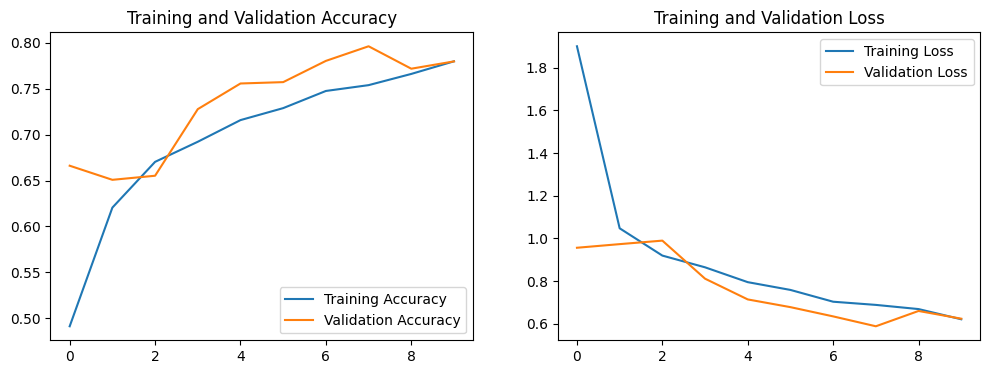

In [16]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [17]:
# save the model
model_A.save('eurosat_conv_model_A.keras')

# 3 & 4. Preventing Overfitting: Regularization

**Techniques to Prevent Overfitting**

1. **Dropout:**

Dropout is a regularization technique that randomly sets a fraction of input units to zero during each forward and backward pass in training. This forces the network to not rely too heavily on any particular neuron, making the model more robust.
You can add Dropout layers after some of the dense or convolutional layers.

2. **L1/L2 Regularization:**

L1 (Lasso) and L2 (Ridge) regularization add a penalty to the loss function based on the size of the weights, discouraging the model from fitting the training data too closely.
L2 is more common and can be added to layers by setting the kernel_regularizer parameter.

3. **Batch Normalization:**

Batch Normalization normalizes the input of each layer, stabilizing the learning process and often improving both training speed and model performance.
It is usually added after convolutional or dense layers.

### Adjusted Cnn setup

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.5148 - loss: 21.8459 - val_accuracy: 0.3315 - val_loss: 4.0551
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.6489 - loss: 2.2456 - val_accuracy: 0.3674 - val_loss: 2.9741
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.6882 - loss: 1.9407 - val_accuracy: 0.3448 - val_loss: 5.0172
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.7100 - loss: 1.8779 - val_accuracy: 0.5211 - val_loss: 2.4117
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.7222 - loss: 1.8792 - val_accuracy: 0.6685 - val_loss: 1.9540
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.7312 - loss: 1.8333 - val_accuracy: 0.4626 - val_loss: 2.6855
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.7482 - loss: 1.7283 - val_accuracy: 0.5157 - val_loss: 2.3748
Ep

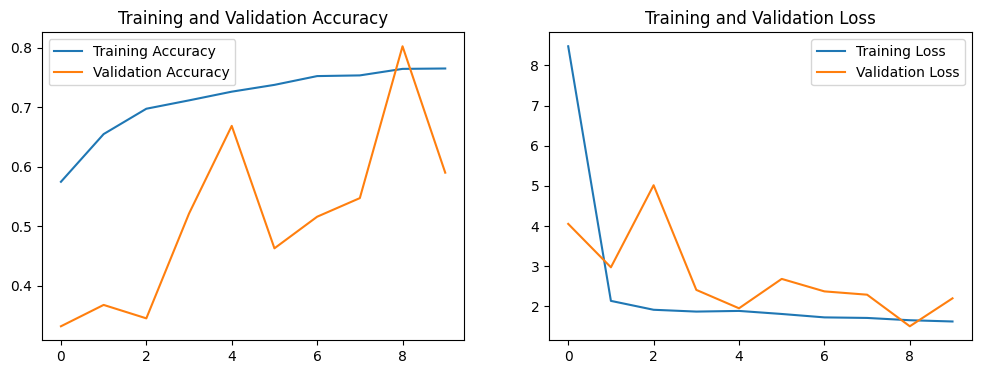

In [18]:
# Set the directory of your dataset
data_dir = './data/2750/'

# Create data generators
train_generator, val_generator, class_names = create_data_generators(data_dir)

# Define input shape and number of classes
input_shape = (64, 64, 3)
num_classes = len(class_names)

# Build the model
model_B = build_cnn_model_with_regularization(input_shape, num_classes)

# Train the model
history = train_model(
    model=model_B, n_epochs=10, n_patience=5, 
    train_generator=train_generator, val_generator=val_generator
)

# Plot training history
plot_training_history(history)


### Why Regularization Can Cause Less Smooth Metric Curves

#### Regularization Adds Noise to Training:
- **Dropout**: Randomly drops units in the network during training, introducing noise and variability, which can cause training loss and accuracy to fluctuate from one batch to another.
- **L1/L2 Regularization**: Penalizes large weights, forcing the model to learn simpler representations. This can slow down learning or cause the model to oscillate as it adjusts weights under these constraints.

#### Regularization Prevents Overfitting, Not Noise:
- Regularization techniques are designed to reduce overfitting by making the model less sensitive to noise in the training data. However, during the training process, these techniques can introduce their own form of noise, leading to fluctuating metrics.
- The primary goal of regularization is to improve generalization, which might come at the cost of stability in training curves.

#### Immediate Impact vs. Long-Term Stability:
- Initially, regularization might make training and validation curves look more erratic because the model is learning under constraints.
- Over time, if regularization is effective, you should observe that the validation metrics (especially loss) improve or stabilize, even if the training metrics fluctuate.

#### Examples of Regularization Impact:
- **Dropout**: Causes each mini-batch to behave differently because different neurons are dropped randomly, which can lead to jumps in accuracy and loss.
- **L2 Regularization (Weight Decay)**: Shrinks weights towards zero, which can slow learning, causing small oscillations as the model gradually finds a balance between minimizing loss and keeping weights small.

#### Strategies to Mitigate Fluctuations While Using Regularization:
- **Gradual Learning Rate Decay**: Use learning rate schedules (like Exponential Decay) to gradually reduce the learning rate over time, helping to stabilize training as the model converges.
- **Increase Batch Size**: Larger batch sizes reduce the variance in gradient updates, leading to smoother training curves even with regularization.
- **Adjust Regularization Strength**: Fine-tune the dropout rate, L1/L2 penalties to find a balance where regularization helps without introducing excessive fluctuations.
- **Use Smoothing for Visualization**: Apply exponential smoothing when plotting metrics to better visualize the overall trends despite inherent fluctuations.

#### Key Takeaways:
- Regularization introduces controlled instability during training but helps in achieving better generalization.
- Fluctuations are normal and expected when regularization is applied; the goal is to see improved stability in validation metrics over the course of training.
- Focus on long-term trends rather than short-term noise when evaluating the effect of regularization on your model.

#### Visualizar los pesos

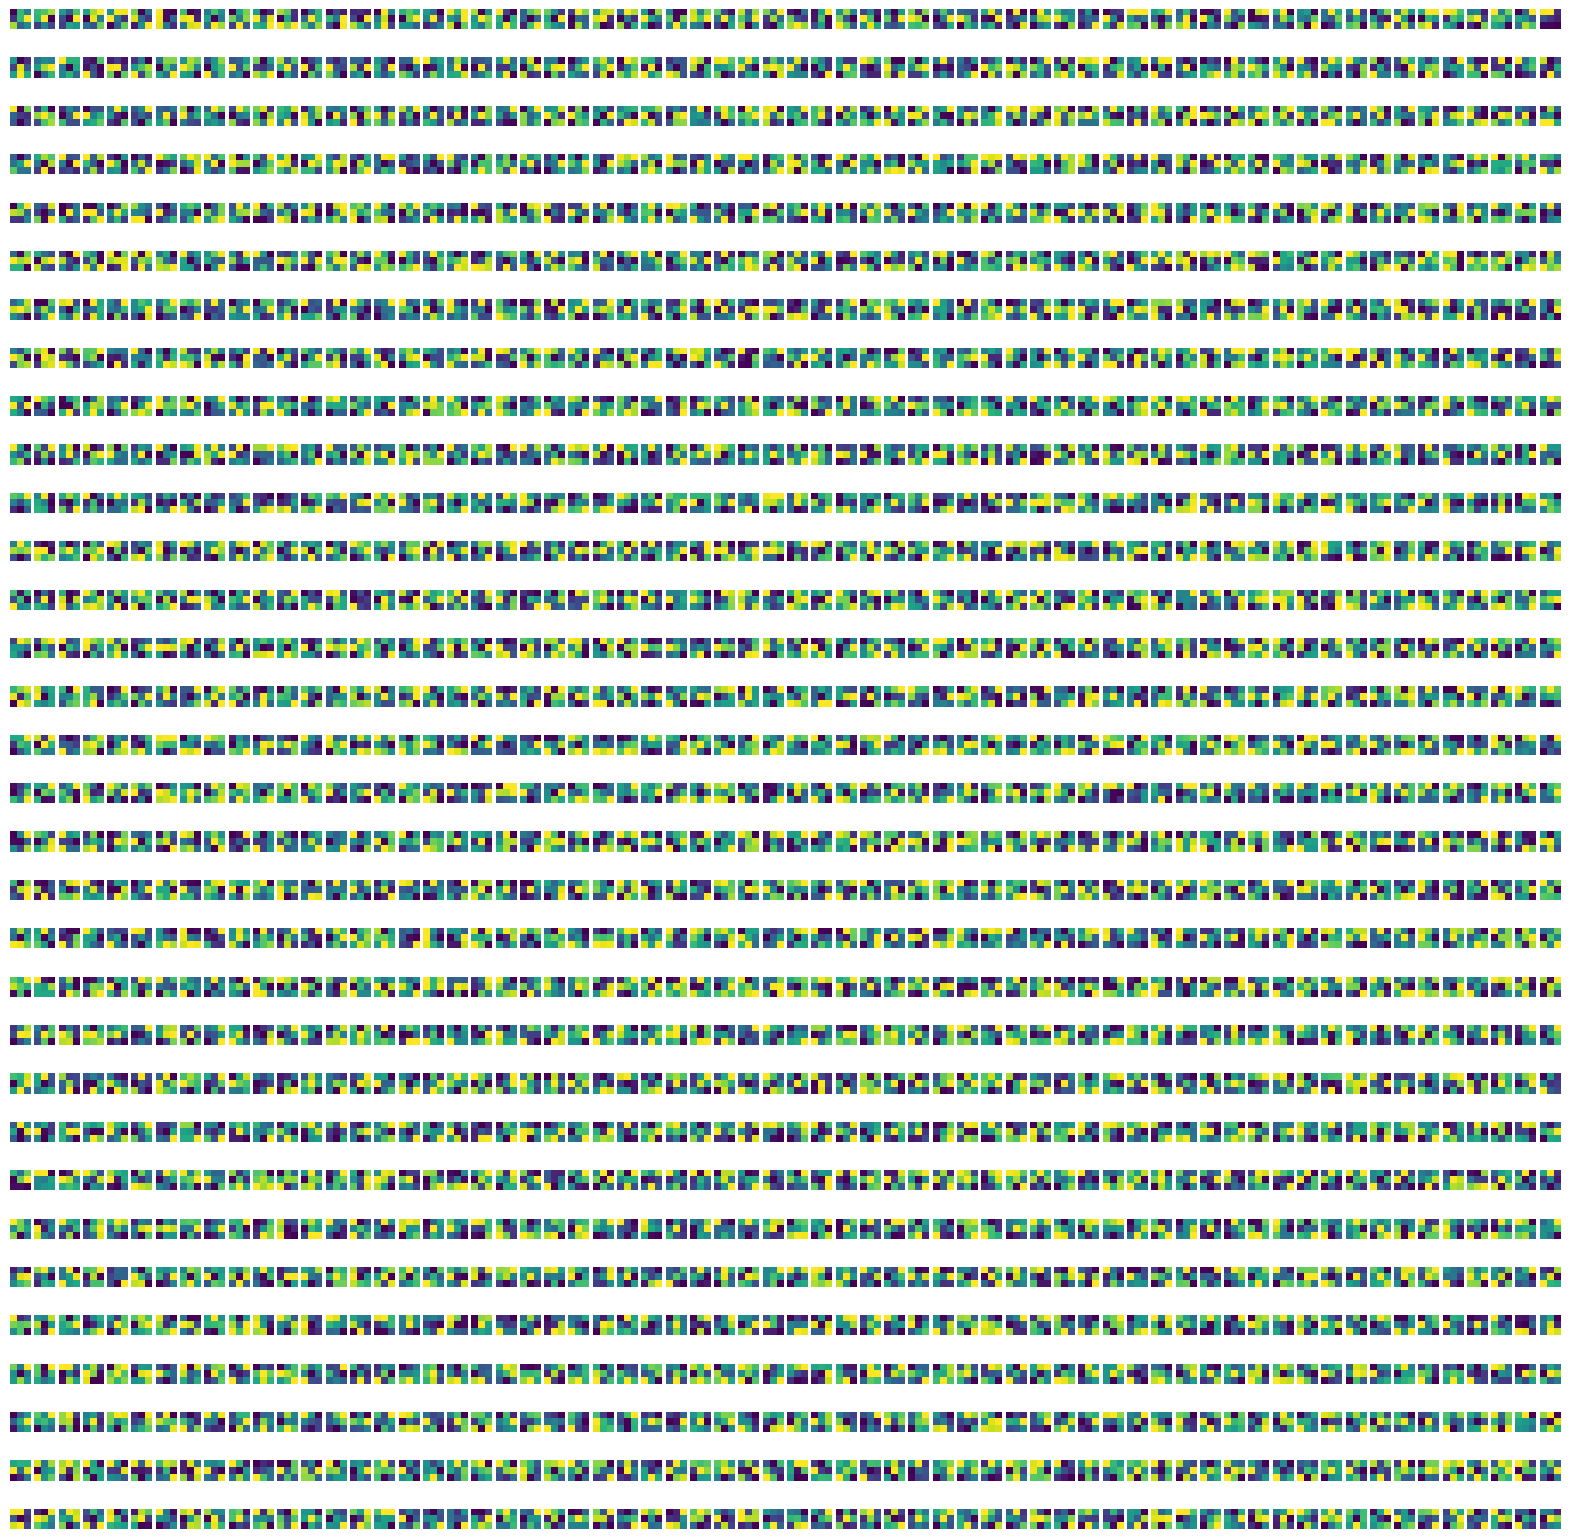

In [19]:
from eurosat_model import visualize_weights

# Visualizar los pesos de la 4 capa convolucional (Determinar si se observan patrones claros)
visualize_weights(model_B, layer_index=4)

### Cross validation

In [20]:
import pandas as pd
from sklearn.model_selection import KFold

# Configuración inicial
data_dir = './data/2750/'  # Directorio de datos
input_shape = (64, 64, 3)
batch_size = 32
num_folds = 3

# Cargar nombres de archivos y etiquetas de clase
all_images = []
all_labels = []

for class_index, class_name in enumerate(os.listdir(data_dir)):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        all_images.append(os.path.join(class_dir, image_name))
        all_labels.append(class_index)

# Convertir listas a arrays de numpy
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Variables para almacenar las métricas de cada pliegue
accuracy_per_fold = []
loss_per_fold = []

# Configurar KFold para la validación cruzada
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Validación cruzada
for fold, (train_indices, val_indices) in enumerate(kf.split(all_images)):
    print(f'Training fold {fold+1}/{num_folds}...')

    # Dividir los datos en entrenamiento y validación para el pliegue actual
    train_images, val_images = all_images[train_indices], all_images[val_indices]
    train_labels, val_labels = all_labels[train_indices], all_labels[val_indices]

    # Convertir las etiquetas a tipo string para que flow_from_dataframe funcione correctamente
    train_df = pd.DataFrame({'filename': train_images, 'class': train_labels.astype(str)})
    val_df = pd.DataFrame({'filename': val_images, 'class': val_labels.astype(str)})

    # Crear generadores de datos
    datagen = ImageDataGenerator(rescale=1.0/255)
    
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=input_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True
    )

    val_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=input_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    )

    # Construir el modelo para el pliegue actual
    model = build_cnn_model_with_regularization(input_shape, len(np.unique(all_labels)))

    # Entrenar el modelo en el pliegue actual
    history = train_model(
        model=model, n_epochs=20, n_patience=5,
        train_generator=train_generator, val_generator=val_generator
    )

    # Evaluar el modelo en los datos de validación del pliegue actual
    scores = model.evaluate(val_generator, verbose=0)
    print(f'Fold {fold+1} - Loss: {scores[0]} - Accuracy: {scores[1]}')

    # Guardar las métricas del pliegue actual
    accuracy_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

# Calcular precisión y pérdida promedio de todos los pliegues
average_accuracy = np.mean(accuracy_per_fold)
average_loss = np.mean(loss_per_fold)
print(f'Average Loss: {average_loss}')
print(f'Average Accuracy: {average_accuracy}')

Training fold 1/3...
Found 18000 validated image filenames belonging to 10 classes.
Found 9000 validated image filenames belonging to 10 classes.
Epoch 1/20


/home/federico/Projects/imgClassification/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


563/563 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5162 - loss: 23.9910 - val_accuracy: 0.2271 - val_loss: 3.5570
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6503 - loss: 2.3537 - val_accuracy: 0.6781 - val_loss: 2.0563
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6946 - loss: 2.0189 - val_accuracy: 0.4743 - val_loss: 2.4948
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7252 - loss: 1.8141 - val_accuracy: 0.5174 - val_loss: 2.3761
Epoch 5/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7407 - loss: 1.8199 - val_accuracy: 0.7193 - val_loss: 1.8220
Epoch 6/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7407 - loss: 1.8442 - val_accuracy: 0.6252 - val_loss: 2.3773
Epoch 7/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7681 - loss: 1.7285 - val_accuracy: 0.5294 - val_loss: 2.5348
Epoch 8/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7628 - loss: 1.7386 - val_accuracy: 0.6484

/home/federico/Projects/imgClassification/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


563/563 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.5188 - loss: 23.9350 - val_accuracy: 0.2971 - val_loss: 3.9059
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6432 - loss: 2.3697 - val_accuracy: 0.6128 - val_loss: 2.1872
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6874 - loss: 1.9484 - val_accuracy: 0.5787 - val_loss: 2.1455
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7256 - loss: 1.7960 - val_accuracy: 0.4412 - val_loss: 3.2166
Epoch 5/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7397 - loss: 1.8149 - val_accuracy: 0.5100 - val_loss: 2.5781
Epoch 6/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7579 - loss: 1.7493 - val_accuracy: 0.6224 - val_loss: 2.0252
Epoch 7/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7636 - loss: 1.7483 - val_accuracy: 0.7240 - val_loss: 1.9114
Epoch 8/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7788 - loss: 1.6884 - val_accuracy: 0.313

/home/federico/Projects/imgClassification/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


563/563 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.5015 - loss: 24.0034 - val_accuracy: 0.3613 - val_loss: 3.3784
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6472 - loss: 2.3761 - val_accuracy: 0.4228 - val_loss: 2.8065
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6948 - loss: 1.9914 - val_accuracy: 0.6053 - val_loss: 2.1463
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7270 - loss: 1.8503 - val_accuracy: 0.6917 - val_loss: 1.9691
Epoch 5/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7443 - loss: 1.8372 - val_accuracy: 0.5164 - val_loss: 2.5571
Epoch 6/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7641 - loss: 1.8073 - val_accuracy: 0.4490 - val_loss: 2.4883
Epoch 7/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7772 - loss: 1.7382 - val_accuracy: 0.6409 - val_loss: 2.1015
Epoch 8/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7694 - loss: 1.7500 - val_accuracy: 0.4368 

In [21]:
# Model evaluation
loss, accuracy = model_B.evaluate(val_generator)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0547 - loss: 6.0729
Loss: 6.416915416717529
Accuracy: 0.08833333104848862


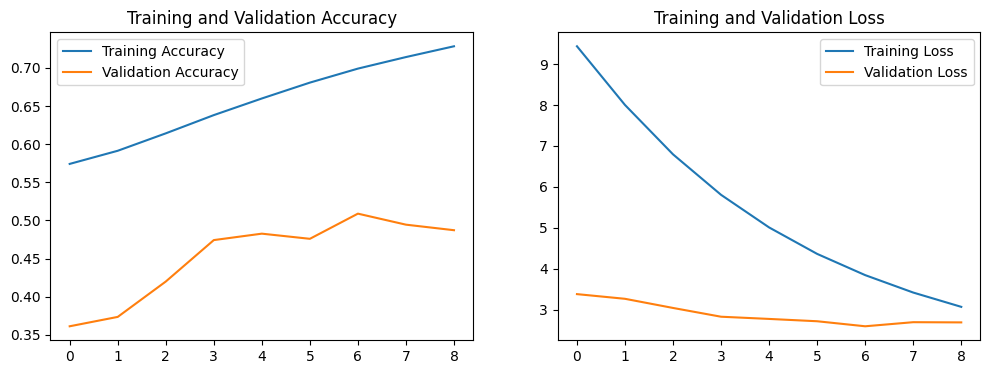

In [22]:
plot_training_history(history, smooth=True, smoothing_factor=0.8)

# 5. Fine tuning exploration

In [23]:
import tensorflow as tf 
print(tf.__version__)#2.17.0

2.17.0


In [24]:
#!pip install keras-tuner --upgrade

In [25]:
import kerastuner as kt
print("KerasTuner version:", kt.__version__)

KerasTuner version: 1.0.5


/tmp/ipykernel_5071/611137280.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [26]:
from eurosat_model import build_model_with_hp
from keras_tuner.tuners import RandomSearch
import os
import shutil

# Defines if starting a fresh tuning session or resuming from a previous checkpoint
start_fresh_tuning_session = True

# Directory paths
tuning_results_dir = 'tuner_results/eurosat_tuning'
temp_val_dir = './temp_val_test_split'

# Restart the tuning session if needed
if start_fresh_tuning_session:
    # Remove the existing tuner results directory
    if os.path.exists(tuning_results_dir):
        shutil.rmtree(tuning_results_dir, ignore_errors=True)
        print("Restarted tuning session: Tuning results directory cleared.")

    # Remove the temporary validation and test split directory if it exists
    if os.path.exists(temp_val_dir):
        shutil.rmtree(temp_val_dir, ignore_errors=True)
        print("Temporary validation/test split directory cleared.")

print("Session setup completed.")

Restarted tuning session: Tuning results directory cleared.
Temporary validation/test split directory cleared.
Session setup completed.


In [27]:
from eurosat_model import create_extended_generators

# Reset validation generator before tuning to avoid state issues
#val_generator.reset()

# Create the data generators
train_generator, val_generator, test_generator = create_extended_generators(
    data_dir=data_dir,
    img_size=(64, 64),
    batch_size=32,
    validation_split=0.2,
    test_split=0.1
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
Found 3600 images belonging to 10 classes.
Found 1800 images belonging to 10 classes.


In [28]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Define steps per epoch
steps_per_epoch = len(train_generator)
validation_steps = val_generator.samples // val_generator.batch_size

# Enhanced Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=3,               # Allow more patience if gradual improvements occur
    restore_best_weights=True, # Restore best weights based on validation loss
    min_delta=0.001,           # Minimum change to be considered as an improvement
    verbose=1                  # Verbose output to provide more insights during training
)

# Model Checkpoint to save the best model during training
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Path to save the best model
    monitor='val_loss',        # Monitor the validation loss
    save_best_only=True,       # Save only the best model during training
    verbose=1                  # Show save messages
)

# Learning rate schedule callback (optional during tuning)
def lr_scheduler(epoch, lr):
    return lr * 0.9  # Reduce the learning rate gradually

lr_callback = LearningRateScheduler(lr_scheduler)

# Use both callbacks during model training
callbacks = [early_stopping, lr_callback, model_checkpoint]

In [29]:
# Perform the hyperparameter search
print("Starting hyperparameter search...")

# Initialize the tuner with the corrected parameters
tuner = RandomSearch(
    build_model_with_hp,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='eurosat_tuning',
    overwrite=True  # Ensures the session starts fresh
)

# Run the hyperparameter search
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=8,  # Define your desired number of epochs per trial
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks #[early_stopping]  # Ensures early stopping will prevent overfitting
)

# Retrieve the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters: ", best_hyperparameters.values)

# Compile the best model with tuned optimizer settings if needed
best_model.compile(
    optimizer=best_model.optimizer,  # Use the optimizer configuration from tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Retrain the best model on the combined training and validation data
print("Retraining the best model on the combined training and validation data...")
best_model.fit(
    train_generator,
    epochs=8,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,#[early_stopping, lr_callback],
    verbose=2
)

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Best Model Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Trial 5 Complete [00h 01m 40s]
val_accuracy: 0.6875

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 08m 09s
Best Hyperparameters:  {'kernel_size_index': 0, 'pool_size_index': 1, 'num_conv_layers': 1, 'conv1_filters': 32, 'conv1_activation': 'relu', 'l2_reg': 0.01, 'bn_momentum': 0.94, 'use_dropout1': True, 'dense_units': 512, 'dense_activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0029854451029190134, 'dropout_rate1': 0.1}
Retraining the best model on the combined training and validation data...
Epoch 1/8


/home/federico/Projects/imgClassification/venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Epoch 1: val_loss improved from inf to 2.16109, saving model to best_model.keras
675/675 - 28s - 41ms/step - accuracy: 0.5233 - loss: 1.7822 - val_accuracy: 0.4138 - val_loss: 2.1611 - learning_rate: 0.0027
Epoch 2/8


2024-11-11 15:13:28.916115: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11393630681006199567
2024-11-11 15:13:28.916173: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14034200610500662573



Epoch 2: val_loss did not improve from 2.16109
675/675 - 0s - 409us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0625 - val_loss: 3.7501 - learning_rate: 0.0024
Epoch 3/8


2024-11-11 15:13:29.185283: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11393630681006199567
2024-11-11 15:13:29.185331: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14034200610500662573



Epoch 3: val_loss improved from 2.16109 to 1.69835, saving model to best_model.keras
675/675 - 25s - 37ms/step - accuracy: 0.5707 - loss: 1.5176 - val_accuracy: 0.5424 - val_loss: 1.6983 - learning_rate: 0.0022
Epoch 4/8

Epoch 4: val_loss did not improve from 1.69835
675/675 - 0s - 16us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1875 - val_loss: 2.5112 - learning_rate: 0.0020
Epoch 5/8


2024-11-11 15:13:54.508581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11393630681006199567
2024-11-11 15:13:54.508630: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14034200610500662573
2024-11-11 15:13:54.514389: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11393630681006199567
2024-11-11 15:13:54.514440: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14034200610500662573



Epoch 5: val_loss did not improve from 1.69835
675/675 - 18s - 27ms/step - accuracy: 0.6086 - loss: 1.3598 - val_accuracy: 0.4872 - val_loss: 1.8972 - learning_rate: 0.0018
Epoch 6/8

Epoch 6: val_loss improved from 1.69835 to 0.27671, saving model to best_model.keras
675/675 - 0s - 275us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.2767 - learning_rate: 0.0016
Epoch 7/8


2024-11-11 15:14:12.796806: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14034200610500662573
2024-11-11 15:14:12.803324: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11393630681006199567
2024-11-11 15:14:12.803376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14034200610500662573



Epoch 7: val_loss did not improve from 0.27671
675/675 - 22s - 32ms/step - accuracy: 0.6293 - loss: 1.2672 - val_accuracy: 0.5566 - val_loss: 1.5819 - learning_rate: 0.0014
Epoch 8/8

Epoch 8: val_loss did not improve from 0.27671
675/675 - 0s - 19us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 3.3980 - learning_rate: 0.0013
Restoring model weights from the end of the best epoch: 6.
 8/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9032 - loss: 0.5735 

2024-11-11 15:14:34.871555: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11393630681006199567
2024-11-11 15:14:34.871590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14034200610500662573
2024-11-11 15:14:34.878922: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11393630681006199567
2024-11-11 15:14:34.878975: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14034200610500662573


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5045 - loss: 1.8411
Best Model Test Loss: 1.8674, Test Accuracy: 0.4867


## 5.1 Simplier model with train, val, test data generators

In [30]:
# construcción del modelo CNN
# Input shape and number of classes for EuroSAT
input_shape = (64, 64, 3)
num_classes = 10  # classes in EuroSAT

# Build and summarize the CNN model
model_C = build_cnn_model(input_shape, num_classes)

model_C.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,458,186 (9.38 MB)

 Trainable params: 2,458,186 (9.38 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Compilar el modelo
model_C.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model_C.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.4149 - loss: 1.5027 - val_accuracy: 0.6806 - val_loss: 0.8804
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.6693 - loss: 0.9016 - val_accuracy: 0.7467 - val_loss: 0.6918
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.7289 - loss: 0.7407 - val_accuracy: 0.7767 - val_loss: 0.6460
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.7608 - loss: 0.6626 - val_accuracy: 0.7267 - val_loss: 0.7566
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.7858 - loss: 0.5949 - val_accuracy: 0.7928 - val_loss: 0.5387
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.8231 - loss: 0.4993 - val_accuracy: 0.8481 - val_loss: 0.4388
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.8310 - loss: 0.4731 - val_accuracy: 0.8428 - val_loss: 0.4416
Epoch 8/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.8378 - loss: 0.4513 - 

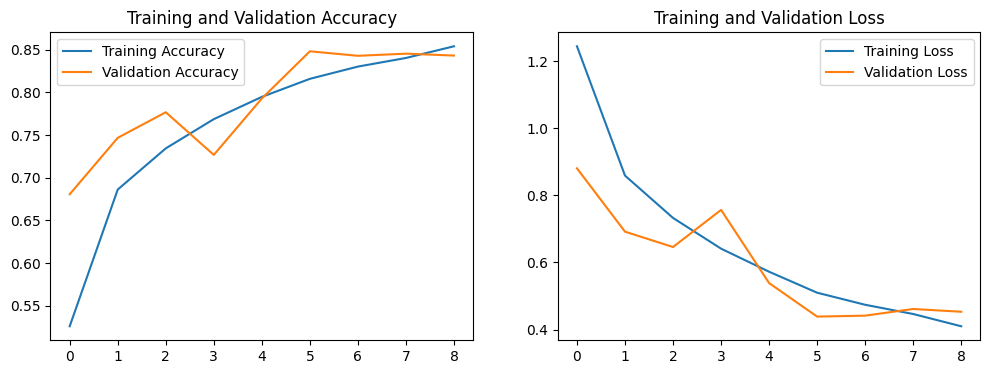

In [32]:
plot_training_history(history)

In [33]:
model_C.save('model_C.keras')

# 6. Test best model

In [34]:
from tensorflow.keras.models import load_model

# Load the best model
model_C = load_model('model_C.keras')


In [35]:
# Generate predictions
predictions = model_C.predict(test_generator)

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2024-11-11 15:21:52.453342: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_65', 4 bytes spill stores, 4 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [36]:
# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Actual class labels
actual_classes = test_generator.classes

# Get the class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Convert predicted indices to class labels
predicted_labels = [class_labels[i] for i in predicted_classes]


In [37]:
# Create a DataFrame with actual and predicted labels
comparison_df = pd.DataFrame({
    'Actual Label': [class_labels[i] for i in actual_classes],
    'Predicted Label': predicted_labels
})

# Display a random sample of comparisons
sample_comparisons = comparison_df.sample(10)
print(sample_comparisons)

              Actual Label       Predicted Label
1080         PermanentCrop         PermanentCrop
1452                 River                 River
373                 Forest                Forest
398                 Forest                Forest
576   HerbaceousVegetation  HerbaceousVegetation
1176         PermanentCrop         PermanentCrop
1762               SeaLake               SeaLake
319                 Forest                Forest
1461                 River                 River
735                Highway               Highway


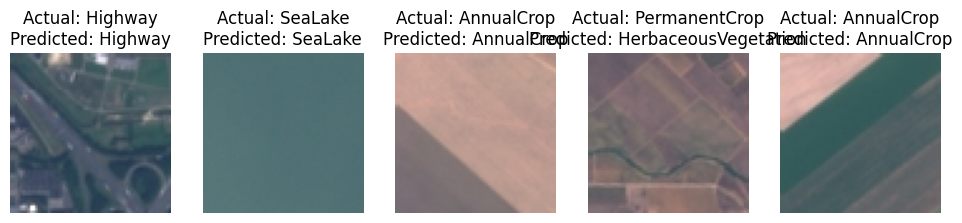

In [38]:
import matplotlib.pyplot as plt

# Get file paths from the test generator
file_paths = test_generator.filepaths

# Select a random subset for visualization
num_samples = 5
indices = np.random.choice(len(file_paths), num_samples, replace=False)

# Plot sample images with actual and predicted labels
plt.figure(figsize=(12, 8))
for i, idx in enumerate(indices):
    img = plt.imread(file_paths[idx])
    plt.subplot(1, num_samples, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {comparison_df['Actual Label'][idx]}\nPredicted: {comparison_df['Predicted Label'][idx]}")
plt.show()


In [39]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(actual_classes, predicted_classes)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.8422222222222222
